In [41]:
import pandas as pd

#tools for baseline
import re
import spacy
from spacy.matcher import Matcher
from tqdm import tqdm 

#visualize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np



In [42]:
train_data = pd.read_csv('Datasets/train.csv').sample(frac=1).reset_index(drop=True)
test_data = pd.read_csv('Datasets/test.csv').sample(frac=1).reset_index(drop=True)
unsupervised_data = pd.read_csv('Datasets/unsupervised.csv').sample(frac=1).reset_index(drop=True)

In [43]:
train_data
X_train = train_data['text']
y_train = train_data['label']

,text,label
0,"Despite its rather salacious title, this is a ...",1
1,The Color Purple is a masterpiece. It displays...,1
2,"When i come on IMDb boards,I'm always fed up w...",0
3,"I have seen this film several times, and watch...",1
4,The idea of making a film about the Beatles so...,1
...,...,...
24995,My name is John Mourby and this is my story ab...,1
24996,Dirty Harry has to track down a rape victim wh...,1
24997,This early version of the tale 'The Student of...,1
24998,"It's a road movie, with a killer on-board. Bri...",1


In [44]:
test_data
X_test = test_data['text']
y_test = test_data['label']

,text,label
0,This movie have 4 parts and every is around 17...,1
1,This show was crap when it first came on. The ...,1
2,BOOOOOOOORRRRRINNGGGGGGGG and STOOOOOOOPIDDDDD...,0
3,"Reba is , without a doubt , one of the worst ""...",0
4,There is no denying it. Sci-fi on TV is diffic...,1
...,...,...
24995,"The entire series, not just The Blue Planet, i...",1
24996,"Licence fees to watch this trash, And pay for ...",0
24997,I can never figure if this is the Artiest Soap...,1
24998,Let me break down this film for you...<br /><b...,0


## 2. Data Exploration

/var/folders/9f/f8xlq5jx22jfg8dxz3jsv41c0000gn/T/ipykernel_98901/1402128858.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


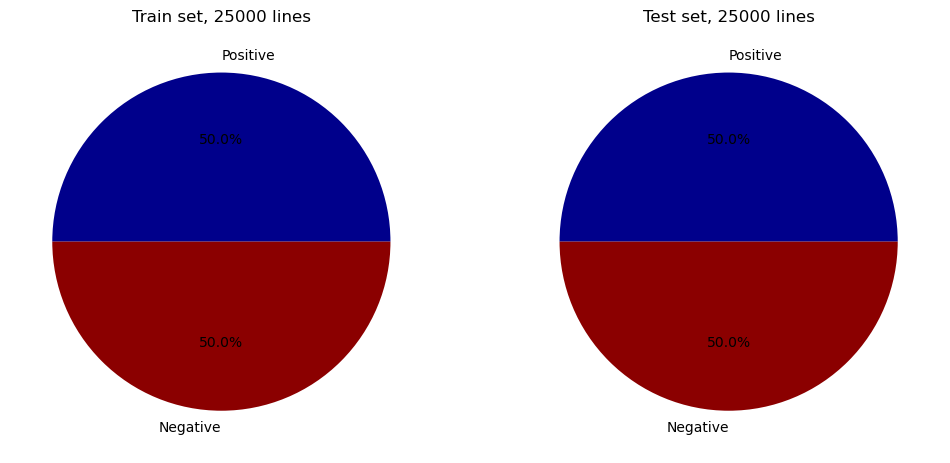

In [45]:
# Check balance

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for i, (df, name) in enumerate(zip([train_data, test_data], ['Train', 'Test'])):
  y = df.label.value_counts().values / len(df) * 100
  ax[i].pie(y, colors=['darkblue', 'darkred'], autopct='%1.1f%%', labels=['Positive', 'Negative'])
  #ax[i].legend()
  ax[i].set_title(f'{name} set, {len(df)} lines')
fig.show()

## 3. Models

### 3.1. Baseline spaCy rule-based matching

In [46]:
good_dictionary = ['incredible', 'good', 'i love', 
                   'i like', 'awesome',
                   'great', 'fantastic', 
                   'excellent', 'brillant',
                   'genius', 'applause', 
                   'well done']

bad_dictionary = ['awful', 'bad', 'i hate', 
                  "i don't like", 'worst', 
                  'horrible', 'dreadful', 
                  'terrible', 'poor', 'boring',
                  'weak script', 'not funny',
                  'rubbish', 'pointless', '']

def get_metrics(y_trues, y_preds, verbose=True):

  recall = recall_score(y_trues, y_preds) * 100
  precision = precision_score(y_trues, y_preds) * 100
  f1 = f1_score(y_trues, y_preds) * 100

  if verbose:
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1: {f1:.2f}')

  return recall, precision, f1

def define_matcher(nlp, vocabulary, anti_vocabulary):
  """
  Objective: get the matcher for one dimension

  Inputs:
    - nlp, spacy.model: the spacy model to get the vocab from
    - vocabulary, list: the vocabulary to take into account
  Outputs:
    - matcher, spacy.matcher: a matcher defined for the dimension
  """
  matcher, matcher_fp = Matcher(nlp.vocab), Matcher(nlp.vocab)

  for voc in vocabulary:
    if voc:
      doc = nlp(voc)
      pattern1 = [{"LOWER": tok.text} for tok in doc]
      matcher.add("extract_pattern",  [pattern1])
  
  if anti_vocabulary:
    for voc in anti_vocabulary:
      if ' ' not in voc and voc:
        doc = nlp(voc)
        pattern3 = [{"LOWER": {"IN": ["was", "did", "had"]}},
                    {"LEMMA": "not", "OP": "?"}, 
                    {"LOWER": doc[0].text}]
        matcher.add("refuse_pattern",  [pattern3])
    
  return matcher

def get_matcher_outputs(docs, matcher):
  """
  Objective: from the texts and a dictionnary of inputs, outputs 0 or 1

  Inputs:
    - texts, list: the list of texts
    - dictionary, dict or list: the list of words that should output the number of words in the texts
  Outputs:
    - ouptuts, list: counts of the dicitonary's words in the texts
  """
  outputs = []
  for doc in docs:
    match = matcher(doc)
    if len(match) == 0:
      outputs.append(0)
    else:
      outputs.append(1)
  return outputs

def get_final_outputs(positive_outputs, negative_outputs):
  """
  Objective: decision function of the two labeling functions for positive and negative

  Inputs:
    - positive_outputs, list: the list of outputs for the positive dictionary
    - negative_outputs; list: the list of outputs for the negative dictionary
  Outputs:
    - outputs, list: the same shape of inputs, that gives 1, 0 or -1 if does not know
  """
  assert len(positive_outputs) == len(negative_outputs), 'ValueError: both lists should have the same size'
  outputs = []
  for pos, neg in zip(positive_outputs, negative_outputs):
    if pos > neg:
      outputs.append(1)
    elif pos < neg:
      outputs.append(0)
    else:
      outputs.append(-1)

  return outputs

def get_spacy_metrics(nlp, my_texts, trues, good_dictionary, bad_dictionary,
                           verbose=True):
  """
  Objective: Automate the loop

  Inputs:
    - nlp, spacy.models
    - my_texts, list: the list of texts
    - trues, np.array: the true outputs to look for
    - positive_outputs, list: the list of outputs for the positive dictionary
    - negative_outputs; list: the list of outputs for the negative dictionary
    - verbose, boolean: display the metrics
  Outputs:
    - precision, float: precision score
    - recall, float: recall score
  """
  positive_matcher = define_matcher(nlp, good_dictionary, bad_dictionary)
  negative_matcher = define_matcher(nlp, bad_dictionary, None)

  docs = nlp.pipe(my_texts)
  positive_outputs = get_matcher_outputs(docs, positive_matcher)
  docs = nlp.pipe(my_texts)
  negative_outputs = get_matcher_outputs(docs, negative_matcher)

  outputs = np.array(get_final_outputs(positive_outputs, negative_outputs))
  _outputs = outputs.copy()
  outputs[outputs == -1] = 1 - trues[outputs == -1]
  recall, precision, f1 = get_metrics(trues, outputs, verbose=verbose)

  return _outputs

nlp = spacy.load("en_core_web_sm", exclude=["ner"])

my_texts = train_data.loc[:, 'text'].apply(lambda x: x.lower()).values

trues = train_data.loc[:, 'label'].values

In [47]:
print('spaCy rule-based results')
final_outputs = get_spacy_metrics(nlp, my_texts, trues, good_dictionary, bad_dictionary,
                           verbose=True)

spaCy rule-based results


### 3.2. Baseline TF-IDF + Logistic regression

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=5, 
                             stop_words='english',
                             )

clf = LogisticRegression(class_weight='balanced', 
                         random_state=11, max_iter=1000)

X_train_tfidf = vectorizer.fit_transform(X_train)

clf.fit(X_train_tfidf, y_train)
y_preds = clf.predict(vectorizer.transform(X_test))
r_tfidf, p_tfidf = get_metrics(y_test, y_preds, verbose=True)